# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

In [1]:
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
env = gym.make('BipedalWalker-v2')

random_seed = 10
env.seed(random_seed)

# from agent import Agent
# agent = Agent(state_size=env.observation_space.shape[0], action_size=env.action_space.shape[0], 
#               random_seed=random_seed)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


[10]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [3]:
env.action_space, env.observation_space

(Box(4,), Box(24,))

In [4]:
action_size = env.action_space.shape[0]
state_size = env.observation_space.shape[0]

In [5]:
action_size, state_size

(4, 24)

In [6]:
env.observation_space.low, env.observation_space.high

(array([-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
        -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
        -inf, -inf], dtype=float32),
 array([inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
        inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf],
       dtype=float32))

In [7]:
env.action_space.low, env.action_space.high

(array([-1., -1., -1., -1.], dtype=float32),
 array([1., 1., 1., 1.], dtype=float32))

### 3. Instantiate DDPG Agent

In [8]:
from agent2 import Agent

agent = Agent(s_size=state_size, a_size=action_size, random_seed=random_seed)

### 4. Train the Agent with DDPG

In [9]:
from collections import deque
import numpy as np
import time
import torch

n_episodes=3000

n_steps=10000
n_learn=10
learn_every=20

R_goal=-100 # TOCHECK
Rs_deque = deque(maxlen=100)
meanRs = [] # plot

dlosses, glosses, dlosses_Q, dlosses_S = [], [], [], []

In [10]:
for i_episode in range(n_episodes):
    
    # # Reset Env
    # env_info = env.reset(train_mode=train_mode)[brain_name]       # reset the environment    
    # S = env_info.vector_observations                   # get the current state (for each agent)
    s = env.reset() # s: state
    #print(s.shape)

    #Rs = np.zeros(num_agents)                            # initialize the score (for each agent)
    R = 0 # R: total reward
    dlosses_, glosses_, dlosses_Q_, dlosses_S_ = [], [], [], []
    
    for i_step in range(n_steps):
    #while True:
        
        a = agent.act(np.reshape(s, [1, -1])) # a=[-1, 1]
        #a *= 2
        #print(a.shape)
        
        # Exploration noise
        # noise = np.random.normal(loc=0, scale=0.1, size=[num_agents, action_size])
        # A += noise
        # A = np.clip(a=A, a_min=-1, a_max=1)

        # env_info = env.step(A)[brain_name]            # send all actions to the environment
        # S2 = env_info.vector_observations          # get next state (for each agent)
        # rewards = env_info.rewards                          # get reward (for each agent)
        # dones = env_info.local_done                         # see if episode finished
        #s2: next_state, r: reward, done/terminal, env: environment
        s2, r, done, _ = env.step(np.reshape(a, [-1]))
        #print(s2.shape, r, done)


        # for s, a, reward, s2, done in zip(S, A, rewards, S2, dones):
        # agent.step(state, action, reward, next_state, done) # send actions to the agent
        agent.step(s, a, r, s2, done)

        R += r                           # update the score (for each agent)
        s = s2                                # roll over states to next time step

        dlosses__, glosses__, dlosses_Q__, dlosses_S__ = [], [], [], []
        if i_step%learn_every == 0:
            for _ in range(n_learn):
                dloss, gloss, dloss_Q, dloss_S = agent.start_learn()
                dlosses__.append(dloss)
                glosses__.append(gloss)
                dlosses_Q__.append(dloss_Q)
                dlosses_S__.append(dloss_S)
            dlosses_.append(np.mean(dlosses__))
            glosses_.append(np.mean(glosses__))
            dlosses_Q_.append(np.mean(dlosses_Q__))
            dlosses_S_.append(np.mean(dlosses_S__))
            
        # print(len(agent.memory))
        # agent.start_learn()

        # if np.any(dones):                                   # exit loop if episode finished
        #     break
        if done:
            break

    #meanR = np.mean(Rs)
    #Rs_deque.append(meanR)
    Rs_deque.append(R)
    meanRs.append(np.mean(Rs_deque)) # plot
    
    dlosses.append(np.mean(dlosses_))
    glosses.append(np.mean(glosses_))
    dlosses_Q.append(np.mean(dlosses_Q_))
    dlosses_S.append(np.mean(dlosses_S_))

    print('\rEpisode {}\tTotal Average Score: {:.2f}\tGloss: {:.2f}\tDloss: {:.2f}\tDlossQ: {:.2f}\tDlossS: {:.2f}'.format(
            i_episode+1, np.mean(Rs_deque), np.mean(glosses_), np.mean(dlosses_), np.mean(dlosses_Q_), np.mean(dlosses_S_)))
    
    if np.mean(Rs_deque) >= R_goal:
        torch.save(agent.g.state_dict(), 'g-bipedal.pth')
        torch.save(agent.d.state_dict(), 'd-bipedal.pth')
        break

Episode 1	Total Average Score: -134.34	Gloss: -0.01	Dloss: 0.08	DlossQ: 0.00	DlossS: 0.08
Episode 2	Total Average Score: -119.48	Gloss: -0.04	Dloss: 7.94	DlossQ: 7.83	DlossS: 0.11
Episode 3	Total Average Score: -114.07	Gloss: -0.04	Dloss: 14.31	DlossQ: 14.18	DlossS: 0.12
Episode 4	Total Average Score: -124.72	Gloss: -0.04	Dloss: 18.09	DlossQ: 17.99	DlossS: 0.10
Episode 5	Total Average Score: -132.80	Gloss: -0.05	Dloss: 15.63	DlossQ: 15.57	DlossS: 0.06
Episode 6	Total Average Score: -130.25	Gloss: -0.05	Dloss: 10.85	DlossQ: 10.77	DlossS: 0.08
Episode 7	Total Average Score: -128.84	Gloss: -0.05	Dloss: 14.27	DlossQ: 14.19	DlossS: 0.08
Episode 8	Total Average Score: -127.49	Gloss: -0.05	Dloss: 14.26	DlossQ: 14.19	DlossS: 0.07
Episode 9	Total Average Score: -123.34	Gloss: -0.05	Dloss: 19.45	DlossQ: 19.38	DlossS: 0.07
Episode 10	Total Average Score: -123.34	Gloss: -0.05	Dloss: 19.97	DlossQ: 19.90	DlossS: 0.08
Episode 11	Total Average Score: -122.11	Gloss: -0.05	Dloss: 20.63	DlossQ: 20.55	Dlo

Episode 90	Total Average Score: -115.55	Gloss: -0.05	Dloss: 55.10	DlossQ: 55.01	DlossS: 0.09
Episode 91	Total Average Score: -115.43	Gloss: -0.05	Dloss: 57.30	DlossQ: 57.21	DlossS: 0.09
Episode 92	Total Average Score: -115.37	Gloss: -0.05	Dloss: 52.25	DlossQ: 52.16	DlossS: 0.09
Episode 93	Total Average Score: -115.26	Gloss: -0.05	Dloss: 53.88	DlossQ: 53.79	DlossS: 0.09
Episode 94	Total Average Score: -115.54	Gloss: -0.05	Dloss: 53.79	DlossQ: 53.70	DlossS: 0.09
Episode 95	Total Average Score: -115.34	Gloss: -0.05	Dloss: 56.65	DlossQ: 56.56	DlossS: 0.09
Episode 96	Total Average Score: -115.29	Gloss: -0.05	Dloss: 52.25	DlossQ: 52.16	DlossS: 0.09
Episode 97	Total Average Score: -115.24	Gloss: -0.05	Dloss: 55.83	DlossQ: 55.75	DlossS: 0.09
Episode 98	Total Average Score: -115.21	Gloss: -0.05	Dloss: 51.60	DlossQ: 51.51	DlossS: 0.09
Episode 99	Total Average Score: -115.17	Gloss: -0.05	Dloss: 55.51	DlossQ: 55.42	DlossS: 0.09
Episode 100	Total Average Score: -115.11	Gloss: -0.05	Dloss: 67.08	Dlo

Episode 178	Total Average Score: -107.73	Gloss: -0.05	Dloss: 93.47	DlossQ: 93.38	DlossS: 0.09
Episode 179	Total Average Score: -107.68	Gloss: -0.05	Dloss: 84.68	DlossQ: 84.58	DlossS: 0.09
Episode 180	Total Average Score: -107.72	Gloss: -0.05	Dloss: 103.74	DlossQ: 103.64	DlossS: 0.10
Episode 181	Total Average Score: -107.75	Gloss: -0.05	Dloss: 91.03	DlossQ: 90.94	DlossS: 0.09
Episode 182	Total Average Score: -107.79	Gloss: -0.05	Dloss: 95.92	DlossQ: 95.82	DlossS: 0.09
Episode 183	Total Average Score: -107.85	Gloss: -0.05	Dloss: 70.99	DlossQ: 70.90	DlossS: 0.09
Episode 184	Total Average Score: -107.90	Gloss: -0.05	Dloss: 77.83	DlossQ: 77.74	DlossS: 0.09
Episode 185	Total Average Score: -107.90	Gloss: -0.05	Dloss: 89.56	DlossQ: 89.47	DlossS: 0.09
Episode 186	Total Average Score: -107.97	Gloss: -0.05	Dloss: 82.72	DlossQ: 82.63	DlossS: 0.09
Episode 187	Total Average Score: -107.97	Gloss: -0.05	Dloss: 89.56	DlossQ: 89.47	DlossS: 0.09
Episode 188	Total Average Score: -107.95	Gloss: -0.05	Dlos

Episode 265	Total Average Score: -104.94	Gloss: -0.05	Dloss: 117.26	DlossQ: 117.16	DlossS: 0.10
Episode 266	Total Average Score: -104.97	Gloss: -0.05	Dloss: 103.41	DlossQ: 103.31	DlossS: 0.09
Episode 267	Total Average Score: -105.00	Gloss: -0.05	Dloss: 115.14	DlossQ: 115.04	DlossS: 0.10
Episode 268	Total Average Score: -104.98	Gloss: -0.05	Dloss: 111.56	DlossQ: 111.46	DlossS: 0.10
Episode 269	Total Average Score: -104.96	Gloss: -0.05	Dloss: 111.88	DlossQ: 111.79	DlossS: 0.10
Episode 270	Total Average Score: -105.00	Gloss: -0.05	Dloss: 109.60	DlossQ: 109.50	DlossS: 0.10
Episode 271	Total Average Score: -104.92	Gloss: -0.05	Dloss: 108.30	DlossQ: 108.20	DlossS: 0.10
Episode 272	Total Average Score: -104.85	Gloss: -0.05	Dloss: 107.65	DlossQ: 107.55	DlossS: 0.10
Episode 273	Total Average Score: -104.79	Gloss: -0.05	Dloss: 113.84	DlossQ: 113.74	DlossS: 0.10
Episode 274	Total Average Score: -104.73	Gloss: -0.05	Dloss: 111.07	DlossQ: 110.97	DlossS: 0.10
Episode 275	Total Average Score: -104.69

Episode 351	Total Average Score: -105.82	Gloss: -0.05	Dloss: 104.89	DlossQ: 104.81	DlossS: 0.08
Episode 352	Total Average Score: -105.79	Gloss: -0.05	Dloss: 110.89	DlossQ: 110.80	DlossS: 0.09
Episode 353	Total Average Score: -105.78	Gloss: -0.05	Dloss: 104.05	DlossQ: 103.96	DlossS: 0.09
Episode 354	Total Average Score: -105.80	Gloss: -0.05	Dloss: 106.00	DlossQ: 105.92	DlossS: 0.08
Episode 355	Total Average Score: -105.84	Gloss: -0.05	Dloss: 104.70	DlossQ: 104.61	DlossS: 0.08
Episode 356	Total Average Score: -105.81	Gloss: -0.05	Dloss: 105.67	DlossQ: 105.59	DlossS: 0.08
Episode 357	Total Average Score: -105.80	Gloss: -0.05	Dloss: 106.65	DlossQ: 106.57	DlossS: 0.09
Episode 358	Total Average Score: -105.83	Gloss: -0.05	Dloss: 100.20	DlossQ: 100.12	DlossS: 0.09
Episode 359	Total Average Score: -106.05	Gloss: -0.05	Dloss: 106.60	DlossQ: 106.52	DlossS: 0.08
Episode 360	Total Average Score: -106.06	Gloss: -0.05	Dloss: 101.05	DlossQ: 100.97	DlossS: 0.08
Episode 361	Total Average Score: -106.02

Episode 437	Total Average Score: -102.51	Gloss: -0.05	Dloss: 109.83	DlossQ: 109.74	DlossS: 0.09
Episode 438	Total Average Score: -102.56	Gloss: -0.05	Dloss: 109.35	DlossQ: 109.26	DlossS: 0.10
Episode 439	Total Average Score: -102.83	Gloss: -0.05	Dloss: 103.19	DlossQ: 103.10	DlossS: 0.09
Episode 440	Total Average Score: -102.83	Gloss: -0.05	Dloss: 107.01	DlossQ: 106.92	DlossS: 0.09
Episode 441	Total Average Score: -102.77	Gloss: -0.05	Dloss: 110.08	DlossQ: 109.99	DlossS: 0.09
Episode 442	Total Average Score: -102.77	Gloss: -0.05	Dloss: 107.64	DlossQ: 107.54	DlossS: 0.09
Episode 443	Total Average Score: -102.73	Gloss: -0.05	Dloss: 113.18	DlossQ: 113.08	DlossS: 0.10
Episode 444	Total Average Score: -102.69	Gloss: -0.05	Dloss: 108.12	DlossQ: 108.03	DlossS: 0.09
Episode 445	Total Average Score: -102.69	Gloss: -0.05	Dloss: 106.01	DlossQ: 105.92	DlossS: 0.09
Episode 446	Total Average Score: -102.64	Gloss: -0.05	Dloss: 108.13	DlossQ: 108.03	DlossS: 0.09
Episode 447	Total Average Score: -102.53

Episode 523	Total Average Score: -104.54	Gloss: -0.05	Dloss: 106.67	DlossQ: 106.57	DlossS: 0.10
Episode 524	Total Average Score: -104.55	Gloss: -0.05	Dloss: 109.60	DlossQ: 109.50	DlossS: 0.10
Episode 525	Total Average Score: -104.58	Gloss: -0.05	Dloss: 110.90	DlossQ: 110.80	DlossS: 0.10
Episode 526	Total Average Score: -104.62	Gloss: -0.05	Dloss: 105.04	DlossQ: 104.94	DlossS: 0.10
Episode 527	Total Average Score: -104.60	Gloss: -0.05	Dloss: 110.58	DlossQ: 110.48	DlossS: 0.10
Episode 528	Total Average Score: -104.58	Gloss: -0.05	Dloss: 114.17	DlossQ: 114.06	DlossS: 0.10
Episode 529	Total Average Score: -104.62	Gloss: -0.05	Dloss: 110.26	DlossQ: 110.15	DlossS: 0.10
Episode 530	Total Average Score: -104.45	Gloss: -0.05	Dloss: 120.03	DlossQ: 119.93	DlossS: 0.10
Episode 531	Total Average Score: -104.47	Gloss: -0.05	Dloss: 120.35	DlossQ: 120.25	DlossS: 0.10
Episode 532	Total Average Score: -104.47	Gloss: -0.05	Dloss: 114.24	DlossQ: 114.14	DlossS: 0.10
Episode 533	Total Average Score: -104.24

Episode 609	Total Average Score: -104.45	Gloss: -0.05	Dloss: 112.87	DlossQ: 112.76	DlossS: 0.11
Episode 610	Total Average Score: -104.46	Gloss: -0.05	Dloss: 116.84	DlossQ: 116.73	DlossS: 0.11
Episode 611	Total Average Score: -104.49	Gloss: -0.05	Dloss: 116.84	DlossQ: 116.74	DlossS: 0.11
Episode 612	Total Average Score: -104.50	Gloss: -0.05	Dloss: 112.54	DlossQ: 112.43	DlossS: 0.11
Episode 613	Total Average Score: -104.35	Gloss: -0.05	Dloss: 111.17	DlossQ: 111.07	DlossS: 0.11
Episode 614	Total Average Score: -104.14	Gloss: -0.05	Dloss: 118.13	DlossQ: 118.02	DlossS: 0.11
Episode 615	Total Average Score: -104.14	Gloss: -0.05	Dloss: 115.86	DlossQ: 115.76	DlossS: 0.11
Episode 616	Total Average Score: -104.02	Gloss: -0.05	Dloss: 119.63	DlossQ: 119.52	DlossS: 0.11
Episode 617	Total Average Score: -103.90	Gloss: -0.05	Dloss: 113.19	DlossQ: 113.09	DlossS: 0.11
Episode 618	Total Average Score: -103.88	Gloss: -0.05	Dloss: 119.71	DlossQ: 119.60	DlossS: 0.11
Episode 619	Total Average Score: -103.63

Episode 695	Total Average Score: -103.45	Gloss: -0.05	Dloss: 100.56	DlossQ: 100.46	DlossS: 0.10
Episode 696	Total Average Score: -103.04	Gloss: -0.05	Dloss: 101.19	DlossQ: 101.09	DlossS: 0.09
Episode 697	Total Average Score: -103.03	Gloss: -0.05	Dloss: 103.49	DlossQ: 103.39	DlossS: 0.10
Episode 698	Total Average Score: -103.07	Gloss: -0.05	Dloss: 107.15	DlossQ: 107.06	DlossS: 0.10
Episode 699	Total Average Score: -103.12	Gloss: -0.05	Dloss: 106.34	DlossQ: 106.24	DlossS: 0.10
Episode 700	Total Average Score: -103.18	Gloss: -0.05	Dloss: 121.08	DlossQ: 120.98	DlossS: 0.10
Episode 701	Total Average Score: -103.15	Gloss: -0.05	Dloss: 108.37	DlossQ: 108.28	DlossS: 0.10
Episode 702	Total Average Score: -103.17	Gloss: -0.05	Dloss: 100.31	DlossQ: 100.22	DlossS: 0.10
Episode 703	Total Average Score: -103.26	Gloss: -0.05	Dloss: 109.35	DlossQ: 109.26	DlossS: 0.10
Episode 704	Total Average Score: -103.30	Gloss: -0.05	Dloss: 106.66	DlossQ: 106.57	DlossS: 0.10
Episode 705	Total Average Score: -103.34

Episode 781	Total Average Score: -117.52	Gloss: -0.05	Dloss: 101.40	DlossQ: 101.29	DlossS: 0.10
Episode 782	Total Average Score: -117.74	Gloss: -0.05	Dloss: 102.57	DlossQ: 102.47	DlossS: 0.10
Episode 783	Total Average Score: -117.93	Gloss: -0.05	Dloss: 94.56	DlossQ: 94.45	DlossS: 0.10
Episode 784	Total Average Score: -118.07	Gloss: -0.05	Dloss: 99.83	DlossQ: 99.73	DlossS: 0.10
Episode 785	Total Average Score: -118.20	Gloss: -0.05	Dloss: 105.70	DlossQ: 105.59	DlossS: 0.10
Episode 786	Total Average Score: -118.65	Gloss: -0.05	Dloss: 99.59	DlossQ: 99.49	DlossS: 0.10
Episode 787	Total Average Score: -118.83	Gloss: -0.05	Dloss: 99.05	DlossQ: 98.95	DlossS: 0.10
Episode 788	Total Average Score: -119.06	Gloss: -0.05	Dloss: 98.66	DlossQ: 98.56	DlossS: 0.10
Episode 789	Total Average Score: -119.34	Gloss: -0.05	Dloss: 102.28	DlossQ: 102.17	DlossS: 0.10
Episode 790	Total Average Score: -119.53	Gloss: -0.05	Dloss: 104.91	DlossQ: 104.81	DlossS: 0.10
Episode 791	Total Average Score: -119.87	Gloss: -0

Episode 868	Total Average Score: -120.71	Gloss: -0.05	Dloss: 86.33	DlossQ: 86.24	DlossS: 0.09
Episode 869	Total Average Score: -120.64	Gloss: -0.05	Dloss: 83.94	DlossQ: 83.84	DlossS: 0.09
Episode 870	Total Average Score: -120.65	Gloss: -0.05	Dloss: 89.07	DlossQ: 88.98	DlossS: 0.09
Episode 871	Total Average Score: -120.39	Gloss: -0.05	Dloss: 86.63	DlossQ: 86.53	DlossS: 0.10
Episode 872	Total Average Score: -119.94	Gloss: -0.05	Dloss: 85.12	DlossQ: 85.03	DlossS: 0.09
Episode 873	Total Average Score: -119.87	Gloss: -0.05	Dloss: 82.96	DlossQ: 82.87	DlossS: 0.09
Episode 874	Total Average Score: -119.84	Gloss: -0.05	Dloss: 92.73	DlossQ: 92.64	DlossS: 0.09
Episode 875	Total Average Score: -119.83	Gloss: -0.05	Dloss: 84.57	DlossQ: 84.48	DlossS: 0.09
Episode 876	Total Average Score: -119.80	Gloss: -0.05	Dloss: 90.53	DlossQ: 90.44	DlossS: 0.09
Episode 877	Total Average Score: -119.50	Gloss: -0.05	Dloss: 83.53	DlossQ: 83.44	DlossS: 0.09
Episode 878	Total Average Score: -120.27	Gloss: -0.05	Dloss:

Episode 956	Total Average Score: -121.14	Gloss: -0.05	Dloss: 72.94	DlossQ: 72.85	DlossS: 0.09
Episode 957	Total Average Score: -121.44	Gloss: -0.05	Dloss: 82.96	DlossQ: 82.87	DlossS: 0.09
Episode 958	Total Average Score: -121.36	Gloss: -0.05	Dloss: 85.75	DlossQ: 85.65	DlossS: 0.10
Episode 959	Total Average Score: -121.39	Gloss: -0.05	Dloss: 81.05	DlossQ: 80.96	DlossS: 0.09
Episode 960	Total Average Score: -121.48	Gloss: -0.05	Dloss: 80.28	DlossQ: 80.18	DlossS: 0.10
Episode 961	Total Average Score: -121.47	Gloss: -0.05	Dloss: 84.57	DlossQ: 84.48	DlossS: 0.09
Episode 962	Total Average Score: -121.49	Gloss: -0.05	Dloss: 74.13	DlossQ: 74.04	DlossS: 0.09
Episode 963	Total Average Score: -121.43	Gloss: -0.05	Dloss: 87.36	DlossQ: 87.26	DlossS: 0.10
Episode 964	Total Average Score: -121.43	Gloss: -0.05	Dloss: 80.52	DlossQ: 80.42	DlossS: 0.10
Episode 965	Total Average Score: -121.34	Gloss: -0.05	Dloss: 74.74	DlossQ: 74.64	DlossS: 0.10
Episode 966	Total Average Score: -121.34	Gloss: -0.05	Dloss:

Episode 1043	Total Average Score: -108.21	Gloss: -0.05	Dloss: 55.25	DlossQ: 55.11	DlossS: 0.13
Episode 1044	Total Average Score: -107.68	Gloss: -0.05	Dloss: 53.95	DlossQ: 53.82	DlossS: 0.13
Episode 1045	Total Average Score: -107.32	Gloss: -0.05	Dloss: 54.53	DlossQ: 54.39	DlossS: 0.13
Episode 1046	Total Average Score: -106.69	Gloss: -0.05	Dloss: 51.65	DlossQ: 51.52	DlossS: 0.13
Episode 1047	Total Average Score: -105.99	Gloss: -0.05	Dloss: 52.75	DlossQ: 52.62	DlossS: 0.13
Episode 1048	Total Average Score: -105.94	Gloss: -0.05	Dloss: 50.78	DlossQ: 50.65	DlossS: 0.13
Episode 1049	Total Average Score: -105.87	Gloss: -0.05	Dloss: 55.87	DlossQ: 55.74	DlossS: 0.13
Episode 1050	Total Average Score: -105.42	Gloss: -0.05	Dloss: 53.51	DlossQ: 53.38	DlossS: 0.13
Episode 1051	Total Average Score: -105.13	Gloss: -0.05	Dloss: 54.16	DlossQ: 54.03	DlossS: 0.13
Episode 1052	Total Average Score: -104.92	Gloss: -0.05	Dloss: 49.41	DlossQ: 49.29	DlossS: 0.13
Episode 1053	Total Average Score: -104.67	Gloss: -

### 5. Plot the result

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

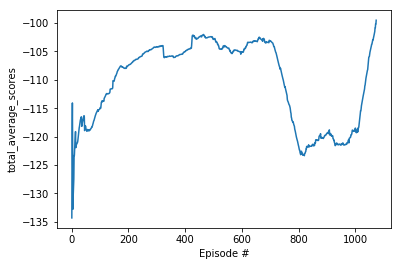

In [12]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(meanRs)+1), meanRs)
plt.ylabel('total_average_scores')
plt.xlabel('Episode #')
plt.show()

### 6. Watch the agent running with saved weights

In [36]:
# Load the saved weights into Pytorch model
agent.g.load_state_dict(torch.load('g-bipedal.pth', map_location='cpu'))
agent.d.load_state_dict(torch.load('d-bipedal.pth', map_location='cpu'))

# env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
# S = env_info.vector_observations                  # get the current states (S) (for each agent)
s = env.reset() # s: state # get the current state (s) (for an agent)
# print(s.shape)

#Rs = np.zeros(num_agents)                          # initialize the total scores (Rs) (for each agent)
R = 0 # R:total reward # initialize the total score (R) (for an agent)

while True:
    #A = agent.act(S)                        # select actions (A) from loaded model agents
    a = agent.act(np.reshape(s, [1, -1])) # a: [-1, +1]    # select action (a) from loaded model agent
    #a = agent.act(s)
    #print(s.shape, a.shape)
    
    # env_info = env.step(A)[brain_name]           # send all actions (A) to tne environment (env)
    # S2 = env_info.vector_observations         # get next states (S2) (for each agent)
    # rewards = env_info.rewards                         # get rewards (for each agent)
    # dones = env_info.local_done                        # see if the episode is done/finished (terminal)
    s2, r, done, _ = env.step(np.reshape(a, [-1]))
    #s2, r, done = env.step(a)
    
    # Rs += env_info.rewards                         # update the total scores (Rs) (for each agent)
    # S = S2                               # roll over current states (S) to next states (S2)
    R += r # update the total score (R) (for an agent)
    s = s2 # roll over current state (s) to next state (s2)
    
    #if np.any(dones):                                  # exit loop if episode is done/finished
    if done: # exit loop if episode is done/finished (terminal)
        break
        
print('Average of total scores: {}'.format(R))

Average of total scores: -106.75700939138544


When finished, you can close the environment.

In [37]:
env.close()